In [1]:
import os
import sys
import subprocess
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
dataset_folder = "../../datasets/synthetic/transactional/"
if not os.path.exists(dataset_folder):
    os.makedirs(dataset_folder)
files = os.listdir(dataset_folder)
print(files)
if len(files) == 0:
    print("No files found in the dataset folder")
    generate_files = "../../utils/file_create.sh"
    os.system(generate_files)

files = os.listdir(dataset_folder)

['triangle_700M.csv', 'triangle_1000M.csv', 'triangle_1100M.csv', 'triangle_800M.csv', 'square_1250M.csv', 'square_2000M.csv', 'square_1000M.csv', 'triangle_1200M.csv', 'square_1500M.csv', 'triangle_900M.csv', 'square_1750M.csv']


In [3]:
result_folder = "../../results/file_read"
if not os.path.exists(result_folder):
    os.makedirs(result_folder)
result_file = os.path.join(result_folder, "file_read.csv")

In [4]:
from cudf_read import cudf_read
from gpu_read import gpu_read
from pandas_read import pandas_read
from python_read import python_read

cpp_executable = "./parallel_read"  # Path to the compiled C++ executable
delimiter = ","  # Define the delimiter to be used by the C++ program

# Check if the result file exists
if os.path.exists(result_file):
    # Load existing results into a DataFrame
    df = pd.read_csv(result_file)
else:
    # Create a new DataFrame with specified columns if the result file does not exist
    df = pd.DataFrame(columns=["file", "method", "time", "memory"])
    df.to_csv(result_file, index=False)

# Iterate over the list of files to process
for file in files:
    print(file)  # Print the current file being processed
    
    # Iterate over the different methods to process the file
    # for method in ["pandas", "cudf", "gpu-csr", "python", "cpp"]:
    for method in ["cudf", "gpu-csr", "cpp-1", "cpp-8"]:
        obj = None  # Initialize the object variable for each method

        # Instantiate the appropriate reader object based on the method
        if method == "pandas":
            obj = pandas_read(dataset_folder + file)
        elif method == "cudf":
            obj = cudf_read(dataset_folder + file)
        elif method == "gpu-csr":
            obj = gpu_read(dataset_folder + file, ',')
        elif method == "python":
            obj = python_read(dataset_folder + file)

        # Check if the file-method combination has already been processed
        if len(df[(df["file"] == file) & (df["method"] == method)]) > 0:
            print(f"\tSkipping {file} with method {method}")  # Skip processing if already done
            continue

        print(f"\tProcessing {file} with method {method}")

        if method == "cpp-1":
            num_cores = 1  # Number of cores to be used for parallel processing
            method = "1-thread Read"
            
            if len(df[(df["file"] == file) & (df["method"] == method)]) > 0:
                print(f"\tSkipping {file} with method {method}")
                continue
                

            try:
                # Run the C++ executable with necessary arguments and capture its output
                result = subprocess.run(
                    [cpp_executable, dataset_folder + file, delimiter, str(num_cores)],
                    capture_output=True, text=True
                )

                # Parse the output from the C++ program
                output_lines = result.stdout.strip().split("\n")
                runtime_line = next(line for line in output_lines if "Time taken" in line)
                # memory_line = next(line for line in output_lines if "Memory used" in line)
                peak_memory_line = next(line for line in output_lines if "Peak memory" in line)

                # Extract runtime and memory usage from the parsed lines
                runtime = float(runtime_line.split(":")[-1].strip().split()[0])
                # memory = int(float(memory_line.split(":")[-1].strip().split()[0]) * 1024) 
                memory = int(float(peak_memory_line.split(":")[-1].strip().split()[0]) * 1024)

            except Exception as e:
                # Print an error message if the subprocess fails
                print(f"\tError running C++ method for {file}: {e}")
                continue
        elif method == "cpp-8":
            num_cores = 8  # Number of cores to be used for parallel processing
            method = "8-thread Read"
            
            # if already processed, skip
            if len(df[(df["file"] == file) & (df["method"] == method)]) > 0:
                print(f"\tSkipping {file} with method {method}")
                continue

            try:
                # Run the C++ executable with necessary arguments and capture its output
                result = subprocess.run(
                    [cpp_executable, dataset_folder + file, delimiter, str(num_cores)],
                    capture_output=True, text=True
                )

                # Parse the output from the C++ program
                output_lines = result.stdout.strip().split("\n")
                runtime_line = next(line for line in output_lines if "Time taken" in line)
                # memory_line = next(line for line in output_lines if "Memory used" in line)
                peak_memory_line = next(line for line in output_lines if "Peak memory" in line)

                # Extract runtime and memory usage from the parsed lines
                runtime = float(runtime_line.split(":")[-1].strip().split()[0])
                # memory = int(float(memory_line.split(":")[-1].strip().split()[0]) * 1024) 
                memory = int(float(peak_memory_line.split(":")[-1].strip().split()[0]) * 1024)

            except Exception as e:
                # Print an error message if the subprocess fails
                print(f"\tError running C++ method for {file}: {e}")
                continue
        else:
            # For Python-based methods, perform the read operation and gather metrics
            obj.read()  # Execute the read operation
            runtime = obj.get_runtime()  # Get the runtime of the operation
            custom_memory = obj.get_custom_memory()  # Get the memory usage details

            # Extract memory usage based on the method type (CPU or GPU)
            if method in ["gpu-csr", "cudf"]:
                memory = int(custom_memory.get("gpu", 0))  # GPU memory usage
            else:
                memory = int(custom_memory.get("cpu", 0))  # CPU memory usage

        del obj  # Delete the object to free memory

        # Create a new row with the file, method, runtime, and memory usage details
        new_row = pd.DataFrame([[file, method, runtime, memory]], columns=["file", "method", "time", "memory"])
        df = pd.concat([df, new_row], ignore_index=True)  # Append the new row to the DataFrame

        # Save the updated DataFrame to the result CSV file after each iteration
        df.to_csv(result_file, index=False)


triangle_700M.csv
	Skipping triangle_700M.csv with method cudf
	Skipping triangle_700M.csv with method gpu-csr
	Processing triangle_700M.csv with method cpp-1
	Skipping triangle_700M.csv with method 1-thread Read
	Processing triangle_700M.csv with method cpp-8
	Skipping triangle_700M.csv with method 8-thread Read
triangle_1000M.csv
	Skipping triangle_1000M.csv with method cudf
	Skipping triangle_1000M.csv with method gpu-csr
	Processing triangle_1000M.csv with method cpp-1
	Skipping triangle_1000M.csv with method 1-thread Read
	Processing triangle_1000M.csv with method cpp-8
	Skipping triangle_1000M.csv with method 8-thread Read
triangle_1100M.csv
	Skipping triangle_1100M.csv with method cudf
	Skipping triangle_1100M.csv with method gpu-csr
	Processing triangle_1100M.csv with method cpp-1
	Skipping triangle_1100M.csv with method 1-thread Read
	Processing triangle_1100M.csv with method cpp-8
	Skipping triangle_1100M.csv with method 8-thread Read
triangle_800M.csv
	Skipping triangle_800M

IndexError: list index out of range

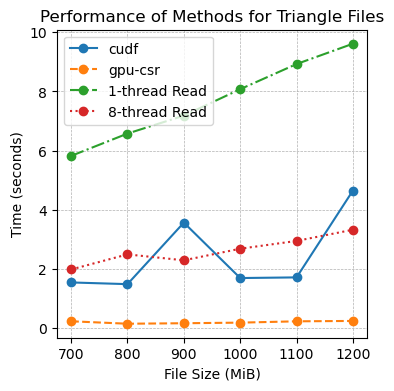

<Figure size 400x400 with 0 Axes>

In [8]:
def file_size_to_mib_corrected(file_name):
    try:
        parts = file_name.split("_")
        size_with_unit = parts[1]  # Get the size with the unit
        # remove the extension
        size_with_unit = size_with_unit.split(".")[0]
        size = float(size_with_unit[:-1])  # Extract the numeric part
        unit = size_with_unit[-1]  # Extract the unit (M or G)
        if unit == "M":
            return size
        elif unit == "G":
            return size * 1024  # Convert GiB to MiB
        else:
            return None  # Unexpected unit

    except Exception as e:
        print(f"Error processing file name: {file_name}, Error: {e}")
        return None

df = pd.read_csv(result_file)


# Reapply the corrected function to the dataset
df["size_mib"] = df["file"].apply(file_size_to_mib_corrected)
df["size_mib"] = df["size_mib"].astype(float)
# sort the dataframe by file size
df = df.sort_values(by='size_mib')


# Regroup and plot again
df["shape"] = df["file"].str.split("_").str[0]
shapes = df["shape"].unique()

# convert memory to MiB
df["memory"] = df["memory"] / 1024 / 1024

# round time to 4 decimal places
df["time"] = df["time"].round(4)

fig_size = (4, 4)
time_threshold = 100  # Threshold for runtime

linestyles = ["-", "--", "-.", ":"]

for shape in shapes:
    subset = df[df["shape"] == shape]
    plt.figure(figsize=fig_size)
    counter = 0
    
    for method in subset["method"].unique():
        method_data = subset[subset["method"] == method]
        
        # Filter the data to only include points below the time threshold
        method_data_below_threshold = method_data[method_data["time"] <= time_threshold]
        # Plot the points within the threshold
        plt.plot(method_data_below_threshold["size_mib"], method_data_below_threshold["time"], marker="o", label=method, linestyle=linestyles[counter])
        counter += 1
        
        # Add a point at the threshold if data exceeds the threshold
        method_data_exceed_threshold = method_data[method_data["time"] > time_threshold]

    
    # plt.xscale("log")
    plt.xlabel("File Size (MiB)")
    plt.ylabel("Time (seconds)")
    plt.title(f"Performance of Methods for {shape.capitalize()} Files")
    plt.legend()
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)
    plt.savefig(result_folder + f"/time_{shape}.svg")


for shape in shapes:
    subset = df[df["shape"] == shape]
    plt.figure(figsize=fig_size)
    counter = 0
    for method in subset["method"].unique():
        method_data = subset[subset["method"] == method]
        plt.plot(method_data["size_mib"], method_data["memory"], marker="o", label=method, linestyle=linestyles[counter])
        counter += 1
    
    # plt.xscale("log")
    plt.xlabel("File Size (MiB)")
    plt.ylabel("Peak Memory (MiB)")
    plt.title(f"Performance of Methods for {shape.capitalize()} Files")
    plt.legend()
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)
    plt.savefig(result_folder + f"/memory_{shape}.svg")
